In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import mrcfile
import pooch
import matplotlib.pyplot as plt

In [4]:



def zyz_to_rotation_matrix(alpha, beta, gamma, device='cuda'):
    """Convert ZYZ Euler angles to rotation matrix"""
    ca, sa = torch.cos(torch.tensor(alpha, device=device)), torch.sin(torch.tensor(alpha, device=device))
    cb, sb = torch.cos(torch.tensor(beta, device=device)), torch.sin(torch.tensor(beta, device=device))
    cg, sg = torch.cos(torch.tensor(gamma, device=device)), torch.sin(torch.tensor(gamma, device=device))
    
    Rz_alpha = torch.tensor([[ca, -sa, 0], [sa, ca, 0], [0, 0, 1]], device=device)
    Ry_beta = torch.tensor([[cb, 0, sb], [0, 1, 0], [-sb, 0, cb]], device=device)
    Rz_gamma = torch.tensor([[cg, -sg, 0], [sg, cg, 0], [0, 0, 1]], device=device)
    
    return Rz_alpha @ Ry_beta @ Rz_gamma


def power_projection_raycast_gpu(data, euler_angles, num_samples=None, 
                                  p=-5, device='cuda', output_size=None, chunk_size=32):
    """
    Ray casting with proper masking of out-of-bounds samples
    """
    if isinstance(data, np.ndarray):
        volume = torch.from_numpy(data).float().to(device)
    else:
        volume = data.to(device)
    
    global_min = volume.min().item()
    
    alpha, beta, gamma = euler_angles
    R = zyz_to_rotation_matrix(alpha, beta, gamma, device)
    
    initial_direction = torch.tensor([1., 0., 0.], device=device)
    initial_up = torch.tensor([0., 1., 0.], device=device)
    
    direction = R @ initial_direction
    up_vector = R @ initial_up
    
    right = torch.cross(up_vector, direction)
    right = right / torch.norm(right)
    up = torch.cross(direction, right)
    up = up / torch.norm(up)
    
    if output_size is None:
        up_extent = torch.abs(up).cpu().numpy()
        right_extent = torch.abs(right).cpu().numpy()
        dim_order = np.argsort(up_extent + right_extent)[::-1]
        height = volume.shape[dim_order[0]]
        width = volume.shape[dim_order[1]]
        output_size = (height, width)
    
    height, width = output_size
    
    # Calculate diagonal
    volume_diagonal = np.sqrt(sum([d**2 for d in volume.shape]))
    
    if num_samples is None:
        num_samples = int(volume_diagonal)
    
    projection = np.zeros((height, width), dtype=np.float32)
    
    center = torch.tensor([volume.shape[0]/2, volume.shape[1]/2, volume.shape[2]/2], 
                          device=device)
    
    extent_up = torch.sqrt(torch.sum(up**2 * torch.tensor(volume.shape, device=device)**2))
    extent_right = torch.sqrt(torch.sum(right**2 * torch.tensor(volume.shape, device=device)**2))
    
    volume_batch = volume.unsqueeze(0).unsqueeze(0)
    
    ray_length = volume_diagonal * 1.1
    
    for start_row in range(0, height, chunk_size):
        end_row = min(start_row + chunk_size, height)
        chunk_height = end_row - start_row
        
        v_coords = torch.linspace(-1, 1, height, device=device)[start_row:end_row]
        u_coords = torch.linspace(-1, 1, width, device=device)
        vv, uu = torch.meshgrid(v_coords, u_coords, indexing='ij')
        
        ray_origins = (center.view(3, 1, 1) + 
                       extent_right/2 * uu.unsqueeze(0) * right.view(3, 1, 1) + 
                       extent_up/2 * vv.unsqueeze(0) * up.view(3, 1, 1) -
                       (ray_length/2) * direction.view(3, 1, 1))
        
        t = torch.linspace(0, 1, num_samples, device=device).view(1, 1, 1, num_samples)
        ray_direction = direction.view(3, 1, 1, 1) * ray_length
        
        sample_points = ray_origins.unsqueeze(3) + t * ray_direction
        
        # Create mask for in-bounds samples
        in_bounds = ((sample_points[0] >= 0) & (sample_points[0] < volume.shape[0]) &
                     (sample_points[1] >= 0) & (sample_points[1] < volume.shape[1]) &
                     (sample_points[2] >= 0) & (sample_points[2] < volume.shape[2]))
        
        normalized_coords = torch.stack([
            2 * sample_points[2] / (volume.shape[2] - 1) - 1,
            2 * sample_points[1] / (volume.shape[1] - 1) - 1,
            2 * sample_points[0] / (volume.shape[0] - 1) - 1,
        ], dim=-1)
        
        grid = normalized_coords.permute(2, 0, 1, 3).unsqueeze(0)
        
        sampled = F.grid_sample(volume_batch, grid, align_corners=True, 
                               mode='bilinear', padding_mode='zeros')
        
        sampled = sampled[0, 0].permute(1, 2, 0)  # [chunk_height, width, num_samples]
        
        # Apply power projection ONLY to in-bounds samples
        data_shifted = sampled - global_min + 1e-10
        data_shifted = torch.clamp(data_shifted, min=1e-6)
        
        # Mask out-of-bounds samples by setting them to a value that won't affect the calculation
        # For power projection, we'll exclude them from the mean
        powered = torch.pow(data_shifted, p)
        
        # Mask out invalid samples
        powered = torch.where(in_bounds, powered, torch.zeros_like(powered))
        
        # Compute mean only over valid samples
        num_valid = in_bounds.sum(dim=2, keepdim=True).float().clamp(min=1)  # Avoid division by zero
        mean_powered = powered.sum(dim=2) / num_valid.squeeze(2)
        
        # Complete the power projection
        log_projection = (1/p) * torch.log(mean_powered + 1e-10)
        chunk_projection = torch.exp(log_projection) + global_min - 1e-10
        
        projection[start_row:end_row, :] = chunk_projection.cpu().numpy()
        
        del sample_points, normalized_coords, grid, sampled, data_shifted, powered, in_bounds
        torch.cuda.empty_cache()
    
    return projection


In [3]:
tomo = pooch.retrieve("https://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-25061/map/emd_25061.map.gz",known_hash=None)

SHA256 hash of downloaded file: c630fc25c5fd89ef39abb1ddec7457d617aa407c5ebd9e090181f1a65fc4f540
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [25]:
with mrcfile.open(tomo) as mrc:
    volume_data = mrc.data.astype(np.float32)

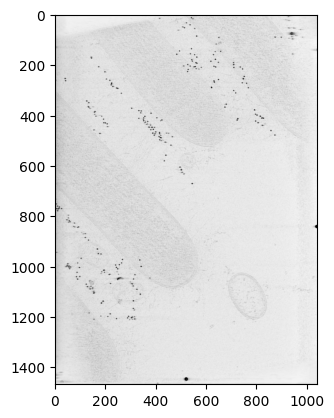

In [26]:
plt.imshow(np.min(volume_data, axis=0), cmap='gray')

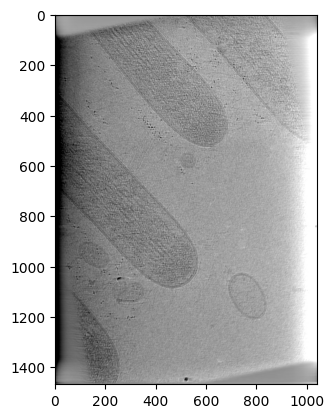

In [27]:
plt.imshow(np.mean(volume_data, axis=0), cmap='gray', vmin=50, vmax=75)

In [39]:
volume_data -= volume_data.mean()
volume_data /= 100

float32


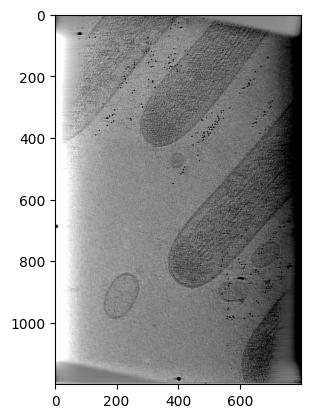

In [42]:
proj_straight = power_projection_raycast_gpu(volume_data, euler_angles=(0,0, 0), p=-5, 
        num_samples=800, chunk_size=4,output_size=(1200,800))
    # Normalize the data to 0-255 range for PNG
print(proj_straight.dtype)
plt.imshow(proj_straight, cmap='gray',vmin=-0.1, vmax=0.1)

float32


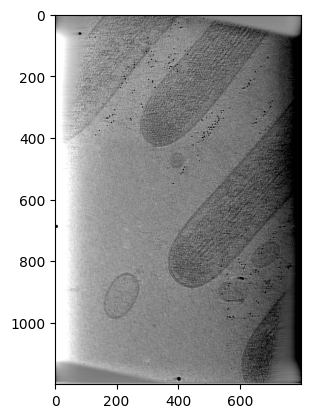

In [43]:
proj_straight = power_projection_raycast_gpu(volume_data, euler_angles=(0,0, 0), p=-2, 
        num_samples=800, chunk_size=4,output_size=(1200,800))
    # Normalize the data to 0-255 range for PNG
print(proj_straight.dtype)
plt.imshow(proj_straight, cmap='gray',vmin=-0.1, vmax=0.1)

float32


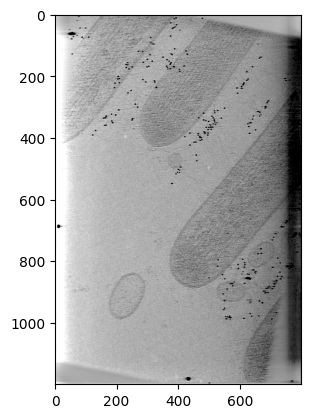

In [47]:
proj_straight = power_projection_raycast_gpu(volume_data, euler_angles=(0,0.2, 0), p=-15, 
        num_samples=800, chunk_size=4,output_size=(1200,800))
    # Normalize the data to 0-255 range for PNG
print(proj_straight.dtype)
plt.imshow(proj_straight, cmap='gray',vmin=-0.2, vmax=0.1)

(array([6.47000e+02, 9.05396e+05, 5.19580e+04, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

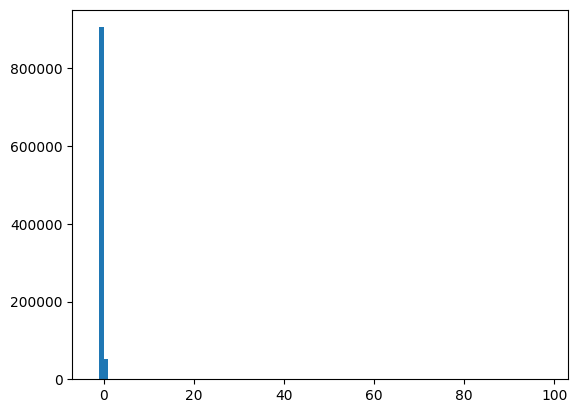

In [41]:
plt.hist(proj_straight.ravel(), bins=100)